In [1]:
# Much of this notebook was borrowed from https://keras.io/examples/vision/captcha_ocr/ and adapted to this problem
# Credit due where credit is due

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import layers

In [2]:
from IPython.display import clear_output as cls

In [3]:
!pip install gdown

# default
# https://drive.google.com/file/d/1EbNVEPuRsujLmC52RGD-sz4-68HK45KH/view?usp=sharing

# augment from default
# https://drive.google.com/file/d/1LqIhGCYUplmidfEkBx3I642kLP4BdKdc/view?usp=sharing

!rm -r dataset
!gdown "https://drive.google.com/uc?id=1LqIhGCYUplmidfEkBx3I642kLP4BdKdc" -O dataset.zip
!unzip dataset.zip -d dataset

cls()

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
# df = pd.read_csv("/kaggle/input/license-plate-text-recognition-dataset/lpr.csv")
df = pd.read_csv('/kaggle/working/dataset/data-modified-resized-augment/train-aug/updated_labels.csv')
# df = df.drop("Unnamed: 0", axis=1)

In [6]:
# df['NameofFile'] = df['NameofFile'].str.replace('.png', '.jpg')
df['images_path'] = df['images_path'].str.replace('.png', '.jpg')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [7]:
df.head(10)

,labels,images_path
0,A7814,DataTrain1-0.jpg
1,A7814,DataTrain1-1.jpg
2,A7814,DataTrain1-2.jpg
3,A7814,DataTrain1-3.jpg
4,A7814,DataTrain1-4.jpg
5,A7814,DataTrain1-5.jpg
6,A7814,DataTrain1-6.jpg
7,A7814,DataTrain1-7.jpg
8,A7814,DataTrain1-8.jpg
9,A7814,DataTrain1-9.jpg


In [8]:
# df.images = "/kaggle/input/license-plate-text-recognition-dataset/cropped_lps/cropped_lps/" + df.images
# df.NameofFile = '/kaggle/working/dataset/data-modified-resized/train/data/' + df.NameofFile
df.images_path = '/kaggle/working/dataset/data-modified-resized-augment/train-aug/data/' + df.images_path

In [9]:
df.head(10)

,labels,images_path
0,A7814,/kaggle/working/dataset/data-modified-resized-...
1,A7814,/kaggle/working/dataset/data-modified-resized-...
2,A7814,/kaggle/working/dataset/data-modified-resized-...
3,A7814,/kaggle/working/dataset/data-modified-resized-...
4,A7814,/kaggle/working/dataset/data-modified-resized-...
5,A7814,/kaggle/working/dataset/data-modified-resized-...
6,A7814,/kaggle/working/dataset/data-modified-resized-...
7,A7814,/kaggle/working/dataset/data-modified-resized-...
8,A7814,/kaggle/working/dataset/data-modified-resized-...
9,A7814,/kaggle/working/dataset/data-modified-resized-...


In [10]:
# labels = df.Vehicleregistrationplate.values.tolist()
# images = df.NameofFile.values.tolist()

labels = df.labels.values.tolist()
images = df.images_path.values.tolist()

In [11]:
MAX_LENGTH = max([len(label) for label in labels])

labels = [label.ljust(MAX_LENGTH) for label in labels]

characters = set(char for label in labels for char in label if char != ' ')
characters = sorted(list(characters))

In [12]:
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  24000
Number of labels found:  24000
Number of unique characters:  36
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [13]:
BATCH_SIZE = 128
IMG_WIDTH = 200
IMG_HEIGHT = 50

In [14]:
with strategy.scope():
    char_to_num = layers.StringLookup(
        vocabulary=characters, mask_token=None
    )

    num_to_char = layers.StringLookup(
        vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
    )

In [15]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    size = len(images)
    indices = np.arange(size)
    
    if shuffle:
        np.random.shuffle(indices)
        
    train_samples = int(size * train_size)
    
    X_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    X_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    
    return X_train, X_valid, y_train, y_valid

In [16]:
X_train, X_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

In [17]:
def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.transpose(img, perm=[1, 0, 2])
    
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
        
    return {"image": img, "label": label}

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [19]:
# plot_images(train_dataset)

In [20]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost
        
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        return y_pred

In [21]:
def build_model():
    input_img = layers.Input(
        shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    
    x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    
    x = layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    
    new_shape = ((IMG_WIDTH // 4), (IMG_HEIGHT // 4) * 64)
    
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)
    
    output = CTCLayer(name="ctc_loss")(labels, x)

    model = tf.keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    
    opt = tf.keras.optimizers.Adam()
    
    model.compile(optimizer=opt)
    
    return model

In [22]:
with strategy.scope():
    model = build_model()

In [23]:
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

In [24]:
EPOCHS = 200
PATIENCE = 5

In [25]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=PATIENCE, restore_best_weights=True
)

In [26]:
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=[es],
)

Epoch 1/200
169/169 [==============================] - 48s 193ms/step - loss: 27.6790 - val_loss: 21.5612
Epoch 2/200
169/169 [==============================] - 29s 170ms/step - loss: 20.9113 - val_loss: 20.4151
Epoch 3/200
169/169 [==============================] - 30s 177ms/step - loss: 20.2263 - val_loss: 19.8905
Epoch 4/200
169/169 [==============================] - 30s 175ms/step - loss: 19.7321 - val_loss: 19.3832
Epoch 5/200
169/169 [==============================] - 30s 177ms/step - loss: 19.1504 - val_loss: 18.7491
Epoch 6/200
169/169 [==============================] - 30s 175ms/step - loss: 18.4935 - val_loss: 18.1995
Epoch 7/200
169/169 [==============================] - 30s 176ms/step - loss: 17.8120 - val_loss: 17.4071
Epoch 8/200
169/169 [==============================] - 30s 175ms/step - loss: 17.0088 - val_loss: 16.4855
Epoch 9/200
169/169 [==============================] - 30s 178ms/step - loss: 16.2412 - val_loss: 15.7287
Epoch 10/200
169/169 [========================

In [27]:
prediction_model = tf.keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

In [28]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :MAX_LENGTH
    ]
    
    output_text = []
    
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
        
    return output_text

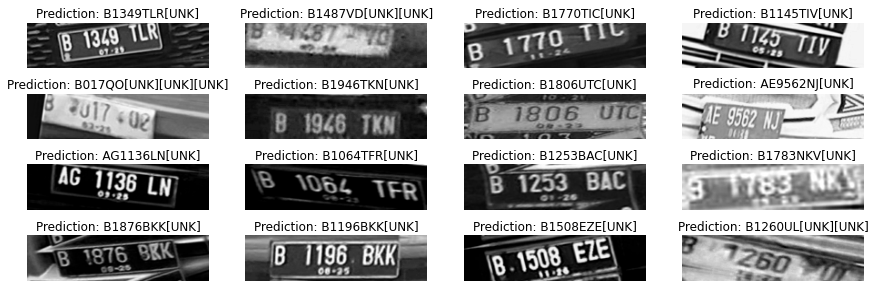

In [29]:
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts) // 8):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()